In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.reset_defaults()

### Model Rationale and Project Trajectory

We picked the crime data because its a very important prediction problem. An algorithm that can predict future murder can be a huge asset to state and local governments. Even more than knowing what next year's crime may look like, we wanted to see which variables may help predict murder. By knowing these variables, these actors could take a proactive approach to trying to predict crime.

Ultimately, we focused on trying to predict the most recent year, and thus chose 2016 to be our test set.

Next, we chose models. We chose to cross validate and tune hyper parameters on regression models that we used in this class: Lasso, Ridge, Random Forest, and Gradient Boosting. However, we needed a baseline in order to compare it to. 

<u> Baseline </u>

We chose a simple auto-regressive model to service as our baseline. Here t represents a year.


 $$ Murder_t = B_0 + B_1 Murder_{t-1} $$
 

<u> Use of Lags and Feature Selection </u>

We decided to include the previous year's number of murders as a feature. This is standard in time series prediction, but it makes us have to eliminate 2006, so our training set becomes 2007-2015.
 
 <u> Metrics </u>
 
 In order to compare models, we need a metric. We threw R<sup>2</sup> after realizing that it was inappropriate. Without any effort, we were getting extremely high R<sup>2</sup> and this is because TSS will be extremely high as it pulls a mean out of the entire sample which will vary widely by MSA. Instead we chose to compare MSE.
 
 
 <u> Hyper-parameter tuning </u>
 
 Lasso/Ridge - We will cross-validate on Lambda. Note we tried to perform scaling but this resulted in inferior performance due to the fact that if you scale on the training set (up to 2015) and apply it to 2016, those distributions aren't necessarily the same and you can't achieve a 0 mean and 1 standard deviation. As a result we chose not to normalize.
 
 Random Forest - We cross validate on the number of trees
 
 Gradient Boosting - We fixed learning rate at default of 0.1 and cross validated on the depth of each tree.
 
 
 <u> Cross Validation Strategy </u> 
 
 Because we are interested in using past data to predict future data, we can't use a simple train-test split.  Instead, we implemented a rolling window cross validation strategy.  This is a time-series modification of leave one out cross validation. In this iterative approach you increase the training set by one year each iteration and your validation window rolls back in time.
 
 In our context, this would mean training on 2007, validating on 2008-2015. Training on 2007-2008, validating on 2009-2015 and taking the average of the validation window at the end.
 
 However, because we are focusing on predicting the most recent year, we modified the rolling window. We restricted the validation set to only be a single year, and it had to be in the range of 2010-2015.  We do this to help simulate our goal which is to use preceeding day to predict the most recent year.
 
 So, our modified rolling window will be:
 Train on 2007-2009 Validate on 2010
 Train on 2008-2010 Validate on 2011
 etc
 
 <u> Do early years matter </u>
 
 Finally, we also wanted to test whether earlier years (ie 2007, 2008) matter when it comes to predicting 2016. So, we run a loop where increase the first year of training set from 2007 to 2012. Within each loop we find the optimal parameter using rolling window, fit the model on the restricted training set using that best model and report test set performance. This will allow us to compare models and see how models may respond to different year ranges when predicting 2016.


In [7]:
#Import Data
final_df= pd.read_json('output/final_imputed1.json')
final_df = final_df.sort_values(['join_key', 'year'])

In [8]:
# Adding Lag murer_mans
final_df['lag_y'] = final_df.groupby(['join_key'])['mur_mans'].shift(1)
final_df = final_df.loc[final_df.year >= 2007, :]

In [9]:
# Don't need these variables for modeling - strings and murder derivatives
no_model_vars = ['violent_crime', 'rate_mur_mans', 'rate_violent_crime', 'city_violent_crime',
                  'city_mur_mans','mur_mans','state_key','join_key','MSA','largest_city','city_key']

In [10]:
# Test Set will be 2015 and 2016
final_two = final_df['year'].isin([2016])
# Need year for indexing but don't put into model
x_vars = final_df.columns.difference(no_model_vars)
model_vars = [x for x in x_vars if x != 'year']

y_var = 'mur_mans'
xtrain = final_df.loc[~final_two, x_vars]
ytrain = final_df.loc[~final_two, y_var]

xtest = final_df.loc[final_two, x_vars]
ytest = final_df.loc[final_two, y_var]

We will use a simple modified Nearest Neighbors Approach as a baseline. We will write a function 
that calculates the mse coming from predicting using the kth nearest neighbors in the training set. Since our test data is 2015 and 2016. The kth nearest neighbor prediction will be taking the average of the kth years for each MSA before 2015

In [11]:
'''
Function
--------
params_vs_errors

This function will take a list of parameters and a list of
avg mse generated by those params and will plot them

Parameters:
    param_list - list of parameters
    avg_val_errors - list of avg mse (one for each mse)
    param_label - String Label for param
'''
def params_vs_avg_mse(param_list, avg_val_errors, param_label, title):
    plt.plot(avg_val_errors)
    plt.xlabel(param_label)
    plt.ylabel("MSE")
    plt.title(title)
    plt.xticks(np.arange(len(param_list)), param_list)
    plt.show()

#### Baseline Model -  Simple Auto-regressive Model

In [21]:
# Autoregressive model
lin_reg = LinearRegression()
auto_reg_results = []
for y in range(2006, 2014):
    lin_reg.fit(xtrain.loc[xtrain.year > y, ['lag_y']].values, ytrain[xtrain.year > y])
    auto_reg_results.append(mean_squared_error(ytest, 
                                               lin_reg.predict(xtest.loc[:, ['lag_y']].values)))

In [16]:
'''
Function
----------
hyper_tuning

This function will control which parameters we tune for each one
of our regressor model. It takes in a string for model type and parameter
and returns a model with that parameter set.

Parameters

model_type (str)  - "LASSO", "RIDGE", "RF", "GB"
param (float) - number for hyper parameter
'''
def hyper_tuning(model_type, param):
    if model_type == "LASSO":
        m = Lasso(alpha=param)
    elif model_type == "RIDGE":
        m = Ridge(alpha=param)
    elif model_type == "RF":
        m = RandomForestRegressor(n_estimators=param, bootstrap=False)
    elif model_type == "GB":
        m = GradientBoostingRegressor(max_depth =param)
    else:
        print("Model type incorrectly specified")
    return(m)

'''
Function
-------------
rolling_window

This function takes a rolling window where validation window is 2010, then 2011, then 2012 etc and training
set is all eyars before it It takes in a model type and param list and returns the parameter that gives
lowest average validation error

Parameters:
model_type - "LASSO", "RIDGE", "RF", "GB"
param_list - list of floats
xtrain - features
ytrain - response
min_year - first year of training set

Returns parameter that gave lowest mean squared error
'''
def rolling_later(model_type, param_list, xtrain, ytrain, min_year):

    errors = []
    for p in param_list:
        m = hyper_tuning(model_type, p)
        # Capture average cross validation error for this parameter
        p_errors = []
        min_year = xtrain['year'].min()
        # If train set has thrown out 2010 we want 2011 to be starting validation
        if min_year >= 2010:
            start_val = min_year + 1
        else:
            start_val = 2010
        
        for yr in range(start_val, 2015):
            val_index = xtrain.year == yr
            tr_index  = xtrain.year < yr
            
            xtr = xtrain.loc[tr_index, model_vars]
            ytr = ytrain[tr_index]
            
            xval = xtrain.loc[val_index, model_vars]
            yval = ytrain[val_index]
            
            m.fit(xtr, ytr)
            # We are going to return error divided by number of years in Val window
            # This will put more weight when validation is later and fewer years
            p_errors.append(mean_squared_error(yval, m.predict(xval)))
        # For this parameter store the average error
        errors.append(np.mean(np.mean(p_errors)))
    # Next I need return the best parameter
    return(param_list[np.argmax(errors)])

In [17]:
# Quick Function to get mse
mse = lambda m: mean_squared_error(ytest, m.predict(xtest.loc[:, model_vars]))

In [19]:
# This function is going to final optimal parameter for each
# one of our regression model and store it. It will do
# this 6 times each each time we drop all variables <= y
# in below loop
# we are going to try to see if we get performance only
# using more recent data
param_vectors = {"LASSO": [0.1, 0.5, 1, 2, 5], 
                 'RIDGE': [x for x in range(1, 10)], 
                 'RF': [100, 200, 250], 
                 'GB': [1,2,3]}
test_errors = {"LASSO":[] , 'RIDGE': [] , 'RF': [], 'GB': []}
best_params = {"LASSO":[], "RIDGE":[], "RF":[], "GB":[]}
for min_year in range(2007, 2014):
    print("Dropping %i" %(min_year - 1))
    # Keep min_year and above
    # first iteration 2006-
    # secon iteration 2007-
    drop_y = final_df.year >= min_year
    xtrain_drop = final_df.loc[(~final_two) & (drop_y), x_vars]
    ytrain_drop = final_df.loc[(~final_two) & (drop_y), y_var]
    # Now Cross Validate on this year range using Rolling Window
    # to final optimal paramter from dictionary above
    for model in param_vectors.keys():
        best_param = rolling_later(model, 
                                   param_vectors[model],
                                   xtrain_drop,
                                   ytrain_drop,
                                   min_year) 
        best_params[model].append(best_param)
        best_m = hyper_tuning(model, best_param)
        # Now fit on training set with certain years dropped and predict on the test
        best_m.fit(xtrain_drop.loc[:, model_vars], ytrain_drop)
        test_errors[model].append(mse(best_m))

Dropping 2006
Dropping 2007
Dropping 2008
Dropping 2009
Dropping 2010
Dropping 2011
Dropping 2012
Dropping 2013


### This plot looks at different models performance on test set as a function of first year of training data

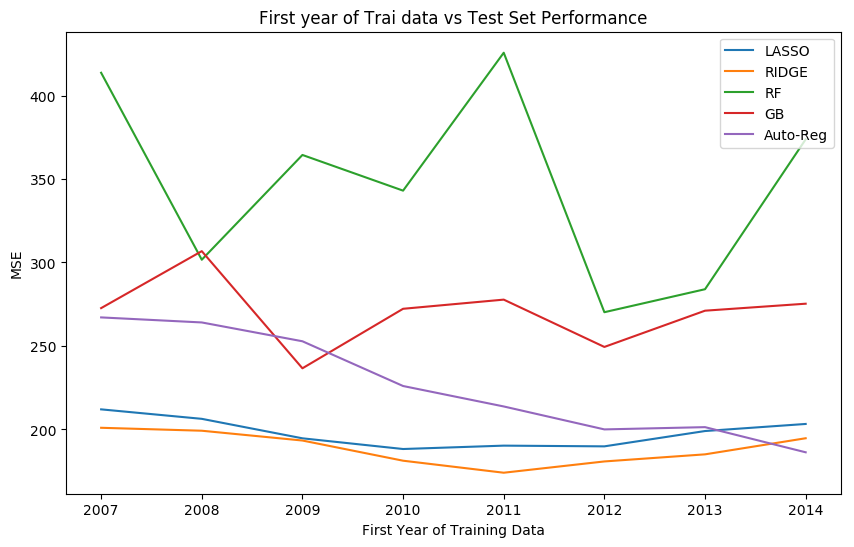

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
for k in test_errors.keys():
    ax.plot(test_errors[k], label=k)
# Plot Auto Regressive
ax.plot(auto_reg_results, label="Auto-Reg")

ax.set_title("First year of Train data vs Test Set Performance")
ax.set_xlabel("First Year of Training Data")
ax.set_ylabel("MSE")
ax.set_xticks(np.arange(8))
ax.set_xticklabels(range(2007, 2015))
ax.legend(loc='best')
plt.show()